### Titanic data set

<b>Download link: </b>https://www.kaggle.com/c/titanic/data

<b>Summary: </b> We create a model which predicts whether a passenger survived on the Titanic

In [ ]:
import pandas as pd

In [2]:
titanic_data = pd.read_csv('train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
unwanted_features = ['PassengerId', 'Name', 'Ticket', 
                     'Cabin', 'SibSp', 'Parch','Embarked']

In [4]:
titanic_data = titanic_data.drop(unwanted_features, axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [5]:
titanic_data = titanic_data.dropna()

In [9]:
titanic_data["Sex"].describe()

count      714
unique       2
top       male
freq       453
Name: Sex, dtype: object

In [11]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])

titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [12]:
features = ['Pclass','Sex','Age','Fare']

titanic_features = titanic_data[features]

titanic_features.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


In [13]:
titanic_features = pd.get_dummies(titanic_features, columns=['Pclass'])

titanic_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [14]:
titanic_target = titanic_data[['Survived']]

titanic_target.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [15]:
from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(titanic_features,
                                                    titanic_target,
                                                    test_size=0.2,
                                                    random_state=1)

In [16]:
X_train.shape, Y_train.shape

((571, 6), (571, 1))

In [30]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [20]:
# tru=ying something different here

X_train1 = X_train.copy()

In [22]:
X_train_tensor = torch.tensor(X_train1.values, dtype = torch.float)

In [23]:
Xtrain_ = torch.from_numpy(X_train.values).float()
Xtest_ = torch.from_numpy(x_test.values).float()

In [24]:
X_train_tensor.shape, Xtrain_.shape

(torch.Size([571, 6]), torch.Size([571, 6]))

In [59]:
Y_train.head()

,Survived
830,1
565,0
148,0
105,0
289,1


In [27]:
Ytrain_ = torch.from_numpy(Y_train.values).view(1, -1)[0]
Ytest_ = torch.from_numpy(y_test.values).view(1, -1)[0]

In [28]:
Ytrain_.shape

torch.Size([571])

In [29]:
input_size = 6
output_size = 2
hidden_size = 10

In [38]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim = -1)

In [39]:
model = Net()

In [40]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

loss_fn = nn.NLLLoss()

In [42]:
epoch_data = []
epochs = 1001

for epoch in range(1, epochs):
    
    optimizer.zero_grad()
    Ypred = model(Xtrain_)
    
    loss = loss_fn(Ypred, Ytrain_)
    loss.backward()
    
    optimizer.step()
    
    Ypred_test = model(Xtest_)
    loss_test = loss_fn(Ypred_test, Ytest_)
    
    _, pred = Ypred_test.data.max(1)
    
    accuracy = pred.eq(Ytest_.data).sum().item() / y_test.values.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])
    
    if epoch % 100 == 0:
        
        print('epoch = %d(%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f'\
             %(epoch, epoch / 150 * 10, loss.data.item(), loss_test.data.item(), accuracy)) 

C:\Users\USER\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch = 100(6%) train loss - 0.42 test loss - 0.42 accuracy - 0.8392
epoch = 200(13%) train loss - 0.41 test loss - 0.41 accuracy - 0.8462
epoch = 300(20%) train loss - 0.40 test loss - 0.40 accuracy - 0.8462
epoch = 400(26%) train loss - 0.40 test loss - 0.40 accuracy - 0.8531
epoch = 500(33%) train loss - 0.39 test loss - 0.39 accuracy - 0.8531
epoch = 600(40%) train loss - 0.39 test loss - 0.39 accuracy - 0.8531
epoch = 700(46%) train loss - 0.39 test loss - 0.38 accuracy - 0.8462
epoch = 800(53%) train loss - 0.39 test loss - 0.38 accuracy - 0.8462
epoch = 900(60%) train loss - 0.38 test loss - 0.38 accuracy - 0.8462
epoch = 1000(66%) train loss - 0.38 test loss - 0.38 accuracy - 0.8462


In [43]:
import pandas as pd

In [44]:
df_epoch_data = pd.DataFrame(epoch_data, 
                             columns=['epoch', 'train_loss', 'test_loss', 'accuracy'])

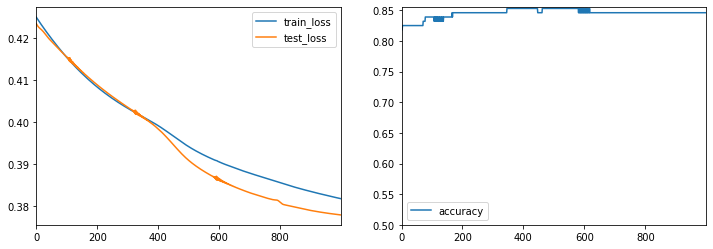

In [46]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

df_epoch_data[['train_loss', 'test_loss']].plot(ax = ax1)
df_epoch_data[['accuracy']].plot(ax=ax2)
plt.ylim(ymin = 0.5)

plt.show()

In [49]:
print("sample train data = ",x_test.values[5])
print("sample target data = ",y_test.values[5])

sample train data =  [ 1. 42. 13.  0.  1.  0.]
sample target data =  [0]


In [50]:
sample = np.array(x_test.values[5])

sample_tensor = torch.from_numpy(sample).float()

In [55]:
out = model(sample_tensor)
out

C:\Users\USER\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([-0.1898, -1.7551], grad_fn=<LogSoftmaxBackward>)

In [56]:
_, predicted = torch.max(out.data, -1)

In [57]:
if predicted.item() == 0: 
    print("Did not survive - ", predicted.item())
elif predicted.item() == 1:
    print("Survived - ", predicted.item())

Did not survive -  0


In [58]:
predicted

tensor(0)